In [617]:
import requests
import time
import re
import pandas as pd
import pprint
import pycrfsuite

import eli5

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from collections import defaultdict

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn_crfsuite import CRF 
from sklearn.model_selection import cross_val_predict # train_test_split <- 쓰려면 쓰기
from sklearn_crfsuite .metrics import flat_classification_report # metrics: measure(Accuracy, score 등) 도구

from pycrfsuite_spacing import TemplateGenerator
from pycrfsuite_spacing import CharacterFeatureTransformer
from pycrfsuite_spacing import sent_to_xy
from bs4 import BeautifulSoup
from konlpy.tag import Kkma as kkm
from konlpy.tag import Okt
#from konlpy.tag import Mecab
#import Mecab
import tweepy


In [618]:
# 참고 사이트 https://yeo0.github.io/data/2018/09/24/5.-%EB%A1%9C%EA%B7%B8%EC%9D%B8%EC%9D%B4-%ED%95%84%EC%9A%94%ED%95%9C-%EC%82%AC%EC%9D%B4%ED%8A%B8%EC%97%90%EC%84%9C%EC%9D%98-%ED%81%AC%EB%A1%A4%EB%A7%81/
# 참고 사이트 2 https://hashcode.co.kr/questions/9084/%EC%9E%A1%ED%94%8C%EB%9E%98%EB%8B%9B-%EB%A1%9C%EA%B7%B8%EC%9D%B8-%ED%9B%84-%EC%8A%A4%ED%81%AC%EB%A0%88%EC%9D%B4%ED%95%91-%EB%AC%B8%EC%9D%98%EB%93%9C%EB%A6%BD%EB%8B%88%EB%8B%A4-%E3%85%9C%E3%85%9C

# 로그인 할 url
url = "https://www.jobplanet.co.kr/users/sign_in?_nav=gb"
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36'
headers = {'Content-type': 'application/json', 'Accept': 'text/plain', 'User-Agent':user_agent}
login_data = {'user':{'email':'hsmy31@hanyang.ac.kr', 'password':'rhkwpgksmswnd!', 'remember_me':'true'}}
session = requests.session()

# 로그인 실행
login_response = session.post(url, json = login_data, headers = headers)

reviews = []

In [619]:
def ind_reviews(code):
    url = "https://www.jobplanet.co.kr/reviews?&industry_id=" + str(code)
    response =  session.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    num = soup.find('span', class_='num') # 리뷰 개수 확인
    num = int(num.get_text().strip())
    import math, random
    pages = math.ceil(num / 10)
    page = random.sample(range(1, pages),30)
    reviews = {}
    for i in page: # 페이지를 랜덤으로 하여 300개의 리뷰 추출
        time.sleep(1)
        url = "https://www.jobplanet.co.kr/reviews?&industry_id=" + str(code) + "&page="+ str(i)
        response =  session.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        label = soup.find_all('h2', class_="us_label") # 한 줄 리뷰 추출
        # 추출한 리뷰에서 태그를 제외한 텍스트만 추출하여 labels 리스트에 저장
        labels = [label.get_text().strip() for label in label[:]]
        star = soup.find_all('div', class_="star_score") # 별점이 포함된 div 추출
        # 추출한 div에서 별점을 나타내는 width 속성의 숫자로 된 부분을 stars 리스트에 저장
        stars = re.findall('[0-9]+[.]+[0-9]', str(star))
        # reviews 딕셔너리에 '리뷰: 별점' 형식으로 추가
        for j in range(len(labels)):
            reviews[labels[j][5:-1]] = stars[j].replace('.0','')
    return reviews

In [620]:
# 각 산업군의 기업 리뷰 스크래핑
reviews1=dict(ind_reviews(1001))

In [621]:
reviews1

{'광역시 소속이라 여기저기 옮겨다녀야 하는 지방공무원 단점을 상쇄할 수 있음': '70',
 '조직문화는 좋으나 과에 따라 업무로드가 힘든 곳이 있음': '70',
 '많은 경험은 하지 못했지만 편하게 일 할 수 있는 환경임': '70',
 '커리어에는 도움이 안됨. 일의 범위가 한정적이며, 가끔은 단순 반복작업 기계가 된 것만 같은 느낌. 이 회사가 존속할수 있을까?': '70',
 '많은 사람들과 함께 일하는 것을 좋아하는 사람에게 추천하고 싶다': '70',
 '국가기관은 뭐니뭐니해도 정규직이 갑. 교육청은 임용고시도 좋은듯': '70',
 '초기기관의 특수성으로 인해 연구 외에 다양한 업무를 수행해야 하나 과학기술연구원 부설로 연봉수준은 높은 편.': '70',
 '폐쇄적이고 출신별 직급별 눈에보이지않는 차별이 있음.': '70',
 '공무원인 신분덕에 월급 꼬박 나오고 연가도 부여받지만 우체국 특성상 인력부족해서 연가 잘 못씀': '70',
 '업무에 집중할 수 있는 환경, 업무 외적인 스트레스 적음': '70',
 '분위기 나쁘지않고 공무원으로 오시면 철밥통입니다.': '80',
 '안정적으로 꾸준히 오래 다닐 수 있는 회사, 그러나 조금 고여있는 회사': '80',
 '워라밸의 끝판왕을 경험할 수 있으나 미국문화에 익숙하지 않으면 위로 올라가기 어려운 곳.': '80',
 '일은 많고 열심히 안하는 직원도 있지만 친절하고 배울만했습니다. 하지만 민원인이 많을 때는 밉기도 했네요': '80',
 '공기좋고 선진국인 호주에서도 수준높은 도시인 캔버라에서 5시 칼퇴가 가능한 직장': '80',
 '중앙부처 중에 그래도 편안하게 일 할 수 있는 조직 분위기': '80',
 '30년전 뒤쳐진 조직 문화, 업무프로세스, 왜 공무원인가?': '80',
 '지방공기업으로 정년보장됩니다.복지포인트도 지급됩니다.': '80',
 '열심히 노력하여 취업한만큼 보람이있는 직장.': '80',
 '공공기관이고, 경찰관, 행정관, 무기계약직으로 이루어진 공무원조직입니다.

In [622]:
text1=list(reviews1.keys())
score1=list(reviews1.values())

In [623]:
sum=0
for i in range(len(score1)):
    sum+=int(score1[i])
avr=sum/len(score1)
print("score 평균값: ", round(avr,3))


score 평균값:  61.227


In [624]:
text1=list(reviews1.keys())
text2=[]
for t in text1:
     text2.append(re.sub('\r',' ', t))
score1=list(reviews1.values())

In [625]:
# kkm 사용
sent_num=0
text1_word=[]
text1_sent=[]
kkm=kkm()
#mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
for i in range(len(text1)):
    text1_pos=kkm.pos(text1[i])
    sent_num+=1
    for t in text1_pos:
        n=list(t)
        
        sent_number="Sentence: {}".format(sent_num)
        n.insert(0, sent_number)
        
        if float(score1[(sent_num-1)]) > avr:
            n.insert(3, '100')
        else: 
            n.insert(3, '0')
        
        #n.insert(3, score1[(sent_num-1)])
        
        text1_word.append(n)

print(len(text1_word))
pprint.pprint(text1_word)

7411
[['Sentence: 1', '광역시', 'NNG', '100'],
 ['Sentence: 1', '소속', 'NNG', '100'],
 ['Sentence: 1', '이', 'VCP', '100'],
 ['Sentence: 1', '라', 'ECD', '100'],
 ['Sentence: 1', '여기저기', 'NNG', '100'],
 ['Sentence: 1', '옮겨다니', 'VV', '100'],
 ['Sentence: 1', '어야', 'ECD', '100'],
 ['Sentence: 1', '하', 'VV', '100'],
 ['Sentence: 1', '는', 'ETD', '100'],
 ['Sentence: 1', '지방', 'NNG', '100'],
 ['Sentence: 1', '공무원', 'NNG', '100'],
 ['Sentence: 1', '단점', 'NNG', '100'],
 ['Sentence: 1', '을', 'JKO', '100'],
 ['Sentence: 1', '상쇄', 'NNG', '100'],
 ['Sentence: 1', '하', 'XSV', '100'],
 ['Sentence: 1', 'ㄹ', 'ETD', '100'],
 ['Sentence: 1', '수', 'NNB', '100'],
 ['Sentence: 1', '있음', 'NNG', '100'],
 ['Sentence: 2', '조직', 'NNG', '100'],
 ['Sentence: 2', '문화', 'NNG', '100'],
 ['Sentence: 2', '는', 'JX', '100'],
 ['Sentence: 2', '좋', 'VA', '100'],
 ['Sentence: 2', '으나', 'ECE', '100'],
 ['Sentence: 2', '과', 'NNG', '100'],
 ['Sentence: 2', '에', 'JKM', '100'],
 ['Sentence: 2', '따르', 'VV', '100'],
 ['Sentence: 2', '

 ['Sentence: 25', '여러', 'MDT', '100'],
 ['Sentence: 25', '부서', 'NNG', '100'],
 ['Sentence: 25', '를', 'JKO', '100'],
 ['Sentence: 25', '경험', 'NNG', '100'],
 ['Sentence: 25', '하', 'XSV', '100'],
 ['Sentence: 25', '어', 'ECS', '100'],
 ['Sentence: 25', '보', 'VV', '100'],
 ['Sentence: 25', 'ㄹ', 'ETD', '100'],
 ['Sentence: 25', '수', 'NNB', '100'],
 ['Sentence: 25', '있', 'VV', '100'],
 ['Sentence: 25', '고', 'ECE', '100'],
 ['Sentence: 25', '계약', 'NNG', '100'],
 ['Sentence: 25', '업무', 'NNG', '100'],
 ['Sentence: 25', '시', 'XSN', '100'],
 ['Sentence: 25', '개인적', 'NNG', '100'],
 ['Sentence: 25', '시간', 'NNG', '100'],
 ['Sentence: 25', '운용', 'NNG', '100'],
 ['Sentence: 25', '가능', 'NNG', '100'],
 ['Sentence: 25', '하', 'XSV', '100'],
 ['Sentence: 25', '나', 'ECE', '100'],
 ['Sentence: 25', '감사', 'NNG', '100'],
 ['Sentence: 25', ',', 'SP', '100'],
 ['Sentence: 25', '소송', 'NNG', '100'],
 ['Sentence: 25', ',', 'SP', '100'],
 ['Sentence: 25', '민원', 'NNG', '100'],
 ['Sentence: 25', '의', 'JKG', '100'],
 ['

 ['Sentence: 53', '어떤', 'MDT', '100'],
 ['Sentence: 53', '상사', 'NNG', '100'],
 ['Sentence: 53', '를', 'JKO', '100'],
 ['Sentence: 53', '만나', 'VV', '100'],
 ['Sentence: 53', '는', 'ETD', '100'],
 ['Sentence: 53', '지', 'NNB', '100'],
 ['Sentence: 53', '에', 'JKM', '100'],
 ['Sentence: 53', '따르', 'VV', '100'],
 ['Sentence: 53', '아', 'ECS', '100'],
 ['Sentence: 53', '회사', 'NNG', '100'],
 ['Sentence: 53', '생활', 'NNG', '100'],
 ['Sentence: 53', '결정', 'NNG', '100'],
 ['Sentence: 54', '시간', 'NNG', '100'],
 ['Sentence: 54', '이', 'JKS', '100'],
 ['Sentence: 54', '많', 'VA', '100'],
 ['Sentence: 54', '아', 'ECD', '100'],
 ['Sentence: 54', '더', 'MAG', '100'],
 ['Sentence: 54', '낫', 'VA', '100'],
 ['Sentence: 54', '은', 'ETD', '100'],
 ['Sentence: 54', '곳', 'NNG', '100'],
 ['Sentence: 54', '으로', 'JKM', '100'],
 ['Sentence: 54', '이직', 'NNG', '100'],
 ['Sentence: 54', '하', 'XSV', '100'],
 ['Sentence: 54', '기', 'ETN', '100'],
 ['Sentence: 54', '위하', 'VV', '100'],
 ['Sentence: 54', '어', 'ECS', '100'],
 ['Sen

 ['Sentence: 96', '관공서', 'NNG', '0'],
 ['Sentence: 96', '알바인', 'NNP', '0'],
 ['Sentence: 96', '만큼', 'NNG', '0'],
 ['Sentence: 96', '정산', 'NNG', '0'],
 ['Sentence: 96', '이', 'JKS', '0'],
 ['Sentence: 96', '확실', 'XR', '0'],
 ['Sentence: 96', '하', 'XSA', '0'],
 ['Sentence: 96', '고', 'ECE', '0'],
 ['Sentence: 96', '꿀', 'NNG', '0'],
 ['Sentence: 96', '알바', 'NNG', '0'],
 ['Sentence: 96', '이기', 'VV', '0'],
 ['Sentence: 96', 'ㄴ', 'ETD', '0'],
 ['Sentence: 96', '하다', 'NNP', '0'],
 ['Sentence: 96', '.', 'SF', '0'],
 ['Sentence: 97', '모두', 'NNG', '0'],
 ['Sentence: 97', '가', 'JKS', '0'],
 ['Sentence: 97', '친절', 'NNG', '0'],
 ['Sentence: 97', '하', 'XSV', '0'],
 ['Sentence: 97', 'ㄴ', 'ETD', '0'],
 ['Sentence: 97', '곳', 'NNG', '0'],
 ['Sentence: 97', '.', 'SF', '0'],
 ['Sentence: 97', '시설', 'NNG', '0'],
 ['Sentence: 97', '이', 'JKS', '0'],
 ['Sentence: 97', '매우', 'MAG', '0'],
 ['Sentence: 97', '깨끗', 'XR', '0'],
 ['Sentence: 97', '하', 'XSA', '0'],
 ['Sentence: 97', 'ㅁ', 'ETN', '0'],
 ['Sentence: 97', 

 ['Sentence: 146', '에', 'JKM', '100'],
 ['Sentence: 146', '나오', 'VV', '100'],
 ['Sentence: 146', '면', 'ECE', '100'],
 ['Sentence: 146', '이', 'MDT', '100'],
 ['Sentence: 146', '곳', 'NNG', '100'],
 ['Sentence: 146', '보다', 'JKM', '100'],
 ['Sentence: 146', '편하', 'VA', '100'],
 ['Sentence: 146', 'ㄴ', 'ETD', '100'],
 ['Sentence: 146', '곳', 'NNG', '100'],
 ['Sentence: 146', '이', 'JKS', '100'],
 ['Sentence: 146', '없', 'VA', '100'],
 ['Sentence: 146', '음', 'ETN', '100'],
 ['Sentence: 146', '.', 'SF', '100'],
 ['Sentence: 146', '야근', 'NNG', '100'],
 ['Sentence: 146', ',', 'SP', '100'],
 ['Sentence: 146', '회식', 'NNG', '100'],
 ['Sentence: 146', '강', 'NNG', '100'],
 ['Sentence: 146', '요', 'JX', '100'],
 ['Sentence: 146', '없', 'VA', '100'],
 ['Sentence: 146', '고', 'ECE', '100'],
 ['Sentence: 146', '칼', 'NNG', '100'],
 ['Sentence: 146', '퇴근', 'NNG', '100'],
 ['Sentence: 146', '가능', 'NNG', '100'],
 ['Sentence: 146', '.', 'SF', '100'],
 ['Sentence: 146', '개인주의', 'NNG', '100'],
 ['Sentence: 146', '라',

 ['Sentence: 185', '아서', 'ECD', '0'],
 ['Sentence: 185', '연구', 'NNG', '0'],
 ['Sentence: 185', '진행', 'NNG', '0'],
 ['Sentence: 185', ',', 'SP', '0'],
 ['Sentence: 185', '고인물', 'NNG', '0'],
 ['Sentence: 185', '로', 'JKM', '0'],
 ['Sentence: 185', '별', 'NNG', '0'],
 ['Sentence: 185', '별', 'XSN', '0'],
 ['Sentence: 185', '사건', 'NNG', '0'],
 ['Sentence: 185', '사고', 'NNG', '0'],
 ['Sentence: 185', '가', 'JKS', '0'],
 ['Sentence: 185', '일어나', 'VV', '0'],
 ['Sentence: 185', 'ㅁ', 'ETN', '0'],
 ['Sentence: 186', '주무', 'NNG', '0'],
 ['Sentence: 186', '부처', 'NNG', '0'],
 ['Sentence: 186', '눈치', 'NNG', '0'],
 ['Sentence: 186', '많이', 'MAG', '0'],
 ['Sentence: 186', '봄', 'NNG', '0'],
 ['Sentence: 186', '앞', 'NNG', '0'],
 ['Sentence: 186', '으로', 'JKM', '0'],
 ['Sentence: 186', '발전', 'NNG', '0'],
 ['Sentence: 186', '가능성', 'NNG', '0'],
 ['Sentence: 186', '은', 'JX', '0'],
 ['Sentence: 186', '높', 'VA', '0'],
 ['Sentence: 186', '음', 'ETN', '0'],
 ['Sentence: 187', '여성', 'NNG', '0'],
 ['Sentence: 187', '을', 

 ['Sentence: 225', '추구', 'NNG', '100'],
 ['Sentence: 225', '하', 'XSV', '100'],
 ['Sentence: 225', '지', 'ECD', '100'],
 ['Sentence: 225', '않', 'VXV', '100'],
 ['Sentence: 225', '는다면', 'ECE', '100'],
 ['Sentence: 225', '만족', 'NNG', '100'],
 ['Sentence: 225', '하', 'XSV', '100'],
 ['Sentence: 225', '고', 'ECE', '100'],
 ['Sentence: 225', '다니', 'VV', '100'],
 ['Sentence: 225', 'ㄹ', 'ETD', '100'],
 ['Sentence: 225', '수', 'NNB', '100'],
 ['Sentence: 225', '있', 'VV', '100'],
 ['Sentence: 225', '을', 'ETD', '100'],
 ['Sentence: 225', '것', 'NNB', '100'],
 ['Sentence: 225', '.', 'SF', '100'],
 ['Sentence: 226', '정말', 'MAG', '100'],
 ['Sentence: 226', '공기업', 'NNG', '100'],
 ['Sentence: 226', '그', 'MDT', '100'],
 ['Sentence: 226', '자체', 'NNG', '100'],
 ['Sentence: 226', '이', 'VCP', '100'],
 ['Sentence: 226', 'ㄴ', 'ETD', '100'],
 ['Sentence: 226', '회사', 'NNG', '100'],
 ['Sentence: 226', '.', 'SF', '100'],
 ['Sentence: 226', '조용하', 'NNG', '100'],
 ['Sentence: 226', '이', 'VCP', '100'],
 ['Sentence: 226'

 ['Sentence: 267', 'ㄹ', 'ETD', '100'],
 ['Sentence: 267', '수', 'NNB', '100'],
 ['Sentence: 267', '있', 'VV', '100'],
 ['Sentence: 267', '는', 'ETD', '100'],
 ['Sentence: 267', '곳', 'NNG', '100'],
 ['Sentence: 267', '.', 'SF', '100'],
 ['Sentence: 267', '분위기', 'NNG', '100'],
 ['Sentence: 267', '가', 'JKS', '100'],
 ['Sentence: 267', '딱딱', 'XR', '100'],
 ['Sentence: 267', '하', 'XSA', '100'],
 ['Sentence: 267', '지', 'ECD', '100'],
 ['Sentence: 267', '않', 'VXV', '100'],
 ['Sentence: 267', '음', 'ETN', '100'],
 ['Sentence: 267', '.', 'SF', '100'],
 ['Sentence: 268', '동종', 'NNG', '100'],
 ['Sentence: 268', '업계', 'NNG', '100'],
 ['Sentence: 268', '급여', 'NNG', '100'],
 ['Sentence: 268', '복지', 'NNG', '100'],
 ['Sentence: 268', '는', 'JX', '100'],
 ['Sentence: 268', '부족', 'NNG', '100'],
 ['Sentence: 268', '하', 'XSV', '100'],
 ['Sentence: 268', '다', 'ECS', '100'],
 ['Sentence: 268', '경력', 'NNG', '100'],
 ['Sentence: 268', '쌓', 'VV', '100'],
 ['Sentence: 268', '기에', 'ECD', '100'],
 ['Sentence: 268', '도

In [18]:
from hanspell import spell_checker

ModuleNotFoundError: No module named 'hanspell'

In [149]:
# PyKoSpacing(띄어쓰기 교정) + Py-Hanspell(맞춤법 교정) 적용
test2_sent_num=0
test2_text1_sent=[]
spacing = Spacing()
#mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
text2_sent=[]
kkm=kkm()

for i in range(len(text2)):
    spelled_sent = spell_checker.check(text2[i])
    hanspell_sent = spelled_sent.checked
    spacing_sent = spacing(hanspell_sent)
    test2_text1_sent.append(spacing_sent)
    test2_sent_num+=1
    text2_pos=kkm.pos(text2[i])
    
    for t in text2_pos:
        n=list(t)
        
        sent_number="Sentence: {}".format(test2_sent_num)
        n.insert(0, sent_number)

        n.insert(3, score1[(test2_sent_num-1)])
        #n.insert(5, score1[(sent_num-1)])
        
        text2_sent.append(n)    

pprint.pprint(text2_sent)

NameError: name 'Spacing' is not defined

In [626]:
# 불용어 제거
# 조사 제거 

text1_del_SW = []
for t in text1_word: 
    if ( (t[2][0] !='E') & (t[2][0] !='J') & (t[2][0] !='S') ):
        text1_del_SW.append(t)

In [627]:
text1_del_SW

[['Sentence: 1', '광역시', 'NNG', '100'],
 ['Sentence: 1', '소속', 'NNG', '100'],
 ['Sentence: 1', '이', 'VCP', '100'],
 ['Sentence: 1', '여기저기', 'NNG', '100'],
 ['Sentence: 1', '옮겨다니', 'VV', '100'],
 ['Sentence: 1', '하', 'VV', '100'],
 ['Sentence: 1', '지방', 'NNG', '100'],
 ['Sentence: 1', '공무원', 'NNG', '100'],
 ['Sentence: 1', '단점', 'NNG', '100'],
 ['Sentence: 1', '상쇄', 'NNG', '100'],
 ['Sentence: 1', '하', 'XSV', '100'],
 ['Sentence: 1', '수', 'NNB', '100'],
 ['Sentence: 1', '있음', 'NNG', '100'],
 ['Sentence: 2', '조직', 'NNG', '100'],
 ['Sentence: 2', '문화', 'NNG', '100'],
 ['Sentence: 2', '좋', 'VA', '100'],
 ['Sentence: 2', '과', 'NNG', '100'],
 ['Sentence: 2', '따르', 'VV', '100'],
 ['Sentence: 2', '업무', 'NNG', '100'],
 ['Sentence: 2', '로드', 'NNG', '100'],
 ['Sentence: 2', '힘들', 'VA', '100'],
 ['Sentence: 2', '곳', 'NNG', '100'],
 ['Sentence: 2', '있음', 'NNG', '100'],
 ['Sentence: 3', '많', 'VA', '100'],
 ['Sentence: 3', '경험', 'NNG', '100'],
 ['Sentence: 3', '하', 'VV', '100'],
 ['Sentence: 3', '못하',

In [628]:
words=[]
for t in text1_del_SW :
    words.append(t[1])

In [629]:
words[:20]

['광역시',
 '소속',
 '이',
 '여기저기',
 '옮겨다니',
 '하',
 '지방',
 '공무원',
 '단점',
 '상쇄',
 '하',
 '수',
 '있음',
 '조직',
 '문화',
 '좋',
 '과',
 '따르',
 '업무',
 '로드']

In [630]:
words_dict = {} # key: value.
for word in words:
    if word in words_dict:
        words_dict[word] += 1
    else:
        words_dict[word] = 1
        
pprint.pprint(words_dict)

{'1': 1,
 '10': 2,
 '15': 1,
 '2': 1,
 '2023': 1,
 '3': 1,
 '30': 1,
 '300': 1,
 '33': 1,
 '4': 1,
 '5': 1,
 '680': 1,
 '8': 1,
 '92': 1,
 'CEO': 1,
 'Dog': 1,
 'Ex': 1,
 'ceo': 1,
 'ㄴ': 1,
 '가': 4,
 '가깝': 2,
 '가끔': 2,
 '가늘': 2,
 '가능': 12,
 '가능성': 4,
 '가득': 1,
 '가스': 1,
 '가장': 3,
 '가져오': 1,
 '가족': 1,
 '가족적': 1,
 '가지': 11,
 '가치': 1,
 '각박': 1,
 '간': 3,
 '간접적': 1,
 '간하': 1,
 '갈': 4,
 '갈리': 1,
 '감': 2,
 '감사': 3,
 '감정': 1,
 '감정자': 1,
 '갑': 2,
 '갑자기': 1,
 '강': 3,
 '강남': 1,
 '강도': 6,
 '강북구': 1,
 '강서구': 1,
 '강조': 1,
 '강하': 1,
 '강한': 1,
 '갖': 2,
 '갖추': 2,
 '같': 14,
 '같이': 2,
 '개': 4,
 '개개인': 1,
 '개로': 1,
 '개발': 4,
 '개방적': 1,
 '개살구': 1,
 '개선': 1,
 '개월': 2,
 '개인': 3,
 '개인적': 2,
 '개인주의': 2,
 '개판': 2,
 '거': 4,
 '거구': 1,
 '거리': 1,
 '거의': 4,
 '거주': 1,
 '거쳐가': 2,
 '건': 1,
 '검사': 3,
 '검사원': 1,
 '것': 38,
 '게이트': 1,
 '겐': 1,
 '격': 1,
 '견디': 2,
 '결정': 1,
 '경력': 6,
 '경력자': 1,
 '경영': 1,
 '경영진': 2,
 '경쟁': 1,
 '경찰관': 1,
 '경찰서': 1,
 '경험': 28,
 '계속': 5,
 '계약': 21,
 '계열': 1,
 '계장': 1,
 '계통': 1,
 '고객': 2,
 '고덕': 

 '트렌드': 1,
 '특별법': 1,
 '특성': 9,
 '특수': 1,
 '특수성': 3,
 '특화': 1,
 '특히': 1,
 '특히나': 1,
 '틀': 1,
 '틀리': 1,
 '팀': 6,
 '팀장': 1,
 '파견': 1,
 '파벌': 3,
 '파악': 1,
 '파워': 1,
 '판치': 1,
 '팡': 1,
 '패턴': 1,
 '팽배': 1,
 '페이퍼': 1,
 '편': 14,
 '편견': 1,
 '편안': 4,
 '편의': 1,
 '편인': 1,
 '편하': 16,
 '편히': 2,
 '평': 1,
 '평가': 1,
 '평범': 1,
 '평생': 5,
 '평온': 1,
 '평화': 2,
 '폐쇄적': 4,
 '포기': 1,
 '포인트': 1,
 '포진': 1,
 '포함': 1,
 '프로그램': 4,
 '프로세스': 2,
 '피곤': 1,
 '필요': 4,
 '하': 310,
 '하나': 4,
 '하다': 4,
 '하루': 2,
 '하면': 3,
 '하심': 1,
 '하지만': 9,
 '학교': 2,
 '학예': 1,
 '한': 7,
 '한결같': 1,
 '한계': 2,
 '한계점': 1,
 '한국': 2,
 '한데': 1,
 '한량': 1,
 '한마디': 2,
 '한번': 2,
 '한번쯤': 1,
 '한심': 1,
 '한정적': 1,
 '함': 6,
 '함께': 4,
 '핫': 1,
 '항상': 1,
 '해': 2,
 '해결': 1,
 '해보': 6,
 '해양': 1,
 '해외': 3,
 '핵심': 1,
 '행복': 2,
 '행사': 1,
 '행정': 3,
 '행정관': 1,
 '행정원': 1,
 '행정직': 2,
 '향상': 1,
 '허술': 1,
 '헤': 1,
 '현실': 1,
 '현장': 6,
 '현재': 2,
 '협력': 1,
 '형': 2,
 '형성': 2,
 '형태': 1,
 '혜택': 1,
 '호봉': 1,
 '호주': 1,
 '혼자': 2,
 '화': 5,
 '화목': 2,
 '확률': 1,
 '확보': 2,
 '확실': 2,

In [631]:
words_df = pd.DataFrame(words_dict, index = [1]) # dic을 이용하여 데이터프레임 생성

words_df = words_df.transpose() # df 행열 전환
#df.columns = ['f'] # df의 열 이름을 'f'로 지정
words_df = words_df.sort_values(by = words_df.columns[0], ascending = False) # 'f'열 값에 따라 내림차순 정렬

In [632]:
words_df[:50]

,1
하,310
이,139
있,138
수,91
곳,81
좋,75
들,63
업무,52
기관,51
없,45


In [633]:
# (수동)불용어 사전 만들기
stopwords=['하', '수', '있', '이','것', '되', '등', '적', '들', '성', '일', '보', '롭', '주']
text1_del_SW2 = []
for t in text1_del_SW: 
    if t[1] not in stopwords:
        text1_del_SW2.append(t)

In [634]:
text1_del_SW2[:20]

[['Sentence: 1', '광역시', 'NNG', '100'],
 ['Sentence: 1', '소속', 'NNG', '100'],
 ['Sentence: 1', '여기저기', 'NNG', '100'],
 ['Sentence: 1', '옮겨다니', 'VV', '100'],
 ['Sentence: 1', '지방', 'NNG', '100'],
 ['Sentence: 1', '공무원', 'NNG', '100'],
 ['Sentence: 1', '단점', 'NNG', '100'],
 ['Sentence: 1', '상쇄', 'NNG', '100'],
 ['Sentence: 1', '있음', 'NNG', '100'],
 ['Sentence: 2', '조직', 'NNG', '100'],
 ['Sentence: 2', '문화', 'NNG', '100'],
 ['Sentence: 2', '좋', 'VA', '100'],
 ['Sentence: 2', '과', 'NNG', '100'],
 ['Sentence: 2', '따르', 'VV', '100'],
 ['Sentence: 2', '업무', 'NNG', '100'],
 ['Sentence: 2', '로드', 'NNG', '100'],
 ['Sentence: 2', '힘들', 'VA', '100'],
 ['Sentence: 2', '곳', 'NNG', '100'],
 ['Sentence: 2', '있음', 'NNG', '100'],
 ['Sentence: 3', '많', 'VA', '100']]

In [635]:
words=[]
for t in text1_del_SW2 :
    words.append(t[1])

In [636]:
words_dict = {} # key: value.
for word in words:
    if word in words_dict:
        words_dict[word] += 1
    else:
        words_dict[word] = 1
        
pprint.pprint(words_dict)

{'1': 1,
 '10': 2,
 '15': 1,
 '2': 1,
 '2023': 1,
 '3': 1,
 '30': 1,
 '300': 1,
 '33': 1,
 '4': 1,
 '5': 1,
 '680': 1,
 '8': 1,
 '92': 1,
 'CEO': 1,
 'Dog': 1,
 'Ex': 1,
 'ceo': 1,
 'ㄴ': 1,
 '가': 4,
 '가깝': 2,
 '가끔': 2,
 '가늘': 2,
 '가능': 12,
 '가능성': 4,
 '가득': 1,
 '가스': 1,
 '가장': 3,
 '가져오': 1,
 '가족': 1,
 '가족적': 1,
 '가지': 11,
 '가치': 1,
 '각박': 1,
 '간': 3,
 '간접적': 1,
 '간하': 1,
 '갈': 4,
 '갈리': 1,
 '감': 2,
 '감사': 3,
 '감정': 1,
 '감정자': 1,
 '갑': 2,
 '갑자기': 1,
 '강': 3,
 '강남': 1,
 '강도': 6,
 '강북구': 1,
 '강서구': 1,
 '강조': 1,
 '강하': 1,
 '강한': 1,
 '갖': 2,
 '갖추': 2,
 '같': 14,
 '같이': 2,
 '개': 4,
 '개개인': 1,
 '개로': 1,
 '개발': 4,
 '개방적': 1,
 '개살구': 1,
 '개선': 1,
 '개월': 2,
 '개인': 3,
 '개인적': 2,
 '개인주의': 2,
 '개판': 2,
 '거': 4,
 '거구': 1,
 '거리': 1,
 '거의': 4,
 '거주': 1,
 '거쳐가': 2,
 '건': 1,
 '검사': 3,
 '검사원': 1,
 '게이트': 1,
 '겐': 1,
 '격': 1,
 '견디': 2,
 '결정': 1,
 '경력': 6,
 '경력자': 1,
 '경영': 1,
 '경영진': 2,
 '경쟁': 1,
 '경찰관': 1,
 '경찰서': 1,
 '경험': 28,
 '계속': 5,
 '계약': 21,
 '계열': 1,
 '계장': 1,
 '계통': 1,
 '고객': 2,
 '고덕': 1,
 '고민': 

 '중진': 1,
 '쥐꼬리': 1,
 '즐겁': 1,
 '즐기': 1,
 '증원': 2,
 '지': 7,
 '지금': 3,
 '지급': 1,
 '지나치': 2,
 '지니': 1,
 '지도': 7,
 '지면': 1,
 '지방': 9,
 '지식': 1,
 '지역': 7,
 '지원': 7,
 '지자': 1,
 '지자체': 3,
 '지적': 1,
 '지키': 2,
 '직': 22,
 '직간': 1,
 '직과': 1,
 '직급': 1,
 '직무': 1,
 '직업': 1,
 '직원': 21,
 '직이': 1,
 '직장': 23,
 '직접': 1,
 '진': 1,
 '진급': 1,
 '진로': 1,
 '진지': 1,
 '진짜': 1,
 '진천군': 1,
 '진행': 3,
 '진흥원': 1,
 '질': 5,
 '짐': 2,
 '집단': 3,
 '집중': 2,
 '짓밟히': 1,
 '징': 1,
 '짙': 1,
 '짜': 3,
 '짜내': 1,
 '짤리': 1,
 '짧': 4,
 '쭉': 1,
 '쯤': 1,
 '찍히': 1,
 '차별': 4,
 '차이': 3,
 '참': 2,
 '참가': 1,
 '창립': 1,
 '창업': 1,
 '찾': 2,
 '책임': 2,
 '챙기': 2,
 '처리': 1,
 '처우': 2,
 '처음': 2,
 '척': 1,
 '천': 1,
 '천문': 1,
 '철': 2,
 '첫': 3,
 '청': 3,
 '청사': 1,
 '청소년': 10,
 '체계': 6,
 '체계적': 2,
 '체육': 1,
 '초기': 1,
 '최고': 4,
 '최근': 1,
 '최대': 1,
 '최소한': 1,
 '최악': 1,
 '추구': 1,
 '추세': 3,
 '추진': 1,
 '추천': 18,
 '축사': 1,
 '축산물': 1,
 '출근': 3,
 '출신': 1,
 '출연': 1,
 '출자': 1,
 '출장': 3,
 '출퇴근': 5,
 '충분히': 1,
 '충실': 2,
 '충청남도': 1,
 '충청북도': 1,
 '취급': 1,
 '취업': 2,
 '치': 2

In [637]:
words_df = pd.DataFrame(words_dict, index = [1]) # dic을 이용하여 데이터프레임 생성

words_df = words_df.transpose() # df 행열 전환
#df.columns = ['f'] # df의 열 이름을 'f'로 지정
words_df = words_df.sort_values(by = words_df.columns[0], ascending = False) # 'f'열 값에 따라 내림차순 정렬

In [638]:
words_df[:50]

,1
곳,81
좋,75
업무,52
기관,51
않,45
없,45
회사,36
많,33
다니,33
사람,32


In [639]:
data = pd.DataFrame(text1_del_SW2)

In [640]:
data

,0,1,2,3
0,Sentence: 1,광역시,NNG,100
1,Sentence: 1,소속,NNG,100
2,Sentence: 1,여기저기,NNG,100
3,Sentence: 1,옮겨다니,VV,100
4,Sentence: 1,지방,NNG,100
...,...,...,...,...
3616,Sentence: 300,위하,VV,0
3617,Sentence: 300,들어오,VV,0
3618,Sentence: 300,싶,VXA,0
3619,Sentence: 300,비,NNG,0


In [641]:
data.columns = ['Sentence: #', 'word', 'POS', 'score']

In [642]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621 entries, 0 to 3620
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sentence: #  3621 non-null   object
 1   word         3621 non-null   object
 2   POS          3621 non-null   object
 3   score        3621 non-null   object
dtypes: object(4)
memory usage: 113.3+ KB


In [643]:
data.describe()

,Sentence: #,word,POS,score
count,3621,3621,3621,3621
unique,300,1339,24,2
top,Sentence: 290,곳,NNG,0
freq,56,81,2294,1898


In [644]:
data['word length'] = data['word'].apply(len)
data.head(10)

,Sentence: #,word,POS,score,word length
0,Sentence: 1,광역시,NNG,100,3
1,Sentence: 1,소속,NNG,100,2
2,Sentence: 1,여기저기,NNG,100,4
3,Sentence: 1,옮겨다니,VV,100,4
4,Sentence: 1,지방,NNG,100,2
5,Sentence: 1,공무원,NNG,100,3
6,Sentence: 1,단점,NNG,100,2
7,Sentence: 1,상쇄,NNG,100,2
8,Sentence: 1,있음,NNG,100,2
9,Sentence: 2,조직,NNG,100,2


In [645]:
sent_n = []
for i in range(len(text1_del_SW2)):
    sent_n.append(re.sub(r'[^0-9]', '', text1_del_SW2[i][0]))

In [646]:
text1_sent2=[]
text1_score2=[]
sent=[]
for i in range(len(sent_n)-1):
    if (int(sent_n[i]) == int(sent_n[i+1])):
        sent.append(text1_del_SW2[i][1])
    else:
        text1_sent2.append(sent)
        text1_score2.append(text1_del_SW2[i][3])        
        #text1_score2.append(int(text1_del_SW2[i][3]))
        sent=[]

In [647]:
text1_score2[:10]

['100', '100', '100', '100', '100', '100', '100', '100', '100', '100']

In [648]:
X_text = text1_sent2
y_score = text1_score2

In [649]:
X_text[:10]

[['광역시', '소속', '여기저기', '옮겨다니', '지방', '공무원', '단점', '상쇄'],
 ['조직', '문화', '좋', '과', '따르', '업무', '로드', '힘들', '곳'],
 ['많', '경험', '못하', '편하', '환경'],
 ['커리어',
  '도움',
  '안됨',
  '일의',
  '범위',
  '한정적',
  '가끔',
  '단순',
  '반복',
  '작업',
  '기계',
  '같',
  '느낌',
  '회사'],
 ['많', '사람', '함께', '일하', '좋아하', '사람', '추천'],
 ['국가', '기관', '뭐', '뭐', '해', '정규직', '갑', '교육청', '임용', '고시', '좋'],
 ['초기',
  '기관',
  '특수성',
  '인하',
  '연구',
  '외',
  '다양',
  '업무',
  '수행',
  '하나',
  '과학',
  '기술',
  '연구원',
  '부설',
  '연봉',
  '수준',
  '높'],
 ['폐쇄적', '출신', '별', '직급', '별', '눈', '보이', '않', '차별'],
 ['공무',
  '원인',
  '신분',
  '덕',
  '월급',
  '꼬박',
  '나오',
  '연가',
  '부여받',
  '우체국',
  '특성',
  '상',
  '인력',
  '부족',
  '연가',
  '잘'],
 ['업무', '집중', '환경', '업무', '외적', '스트레스']]

In [650]:
tokenizer = Tokenizer()
X_text_token = tokenizer.fit_on_texts(X_text)

In [651]:
X_text_token

In [652]:
print(len(tokenizer.word_index))
print(tokenizer.word_index)
# 빈도수가 높은 단어 순서대로 index 부여

1290
{'좋': 1, '업무': 2, '기관': 3, '곳': 4, '않': 5, '없': 6, '사람': 7, '공공': 8, '다니': 9, '근무': 10, '많': 11, '경험': 12, '일하': 13, '공무원': 14, '분위기': 15, '직': 16, '직원': 17, '계약': 18, '복지': 19, '회사': 20, '공기업': 21, '크': 22, '잘': 23, '편하': 24, '직장': 25, '다양': 26, '안': 27, '생각': 28, '조직': 29, '대하': 30, '다': 31, '급여': 32, '환경': 33, '정규직': 34, '나쁘': 35, '문화': 36, '추천': 37, '안정적': 38, '가능': 39, '가지': 40, '청소년': 41, '싶': 42, '분': 43, '기업': 44, '사업': 45, '지방': 46, '같': 47, '특성': 48, '배우': 49, '하지만': 50, '보장': 51, '편': 52, '사회': 53, '발전': 54, '장점': 55, '매우': 56, '따르': 57, '높': 58, '별': 59, '상': 60, '시간': 61, '그': 62, '나': 63, '워': 64, '그냥': 65, '단점': 66, '오래': 67, '중': 68, '위치': 69, '민원': 70, '지원': 71, '및': 72, '자기': 73, '한': 74, '지': 75, '많이': 76, '지역': 77, '오': 78, '자유': 79, '있음': 80, '그렇': 81, '퇴근': 82, '지도': 83, '힘들': 84, '국가': 85, '기술': 86, '연구원': 87, '부족': 88, '조금': 89, '워라밸': 90, '때': 91, '칼': 92, '정년': 93, '만큼': 94, '보람': 95, '느끼': 96, '아니': 97, '수평적': 98, '그리고': 99, '현장': 100, '때문': 101, '강도': 1

In [654]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt=0 # threshold 보다 적은 빈도의 단어 수 count
total_freq = 0
rare_freq = 0

for k, v in tokenizer.word_counts.items():
    total_freq = total_freq + v
    
    if(v < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + v

In [655]:
print(total_cnt)
print(rare_cnt)


1290
776


In [656]:
vocab_size = total_cnt - rare_cnt + 1
print(vocab_size)

515


In [657]:
len(X_text)

299

In [658]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_text)
X_text = tokenizer.texts_to_sequences(X_text)

X_train, X_test, y_train, y_test = train_test_split(X_text, y_score, test_size=0.3, random_state=111)
#X_train = tokenizer.texts_to_sequences(X_text[:200])
#X_test = tokenizer.texts_to_sequences(X_text[201:])

In [659]:
len(X_train)

209

In [660]:
X_test[:10]

[[14, 29, 34, 54],
 [318, 53, 12, 14, 30],
 [22, 6, 465, 9, 1],
 [158, 488, 489, 270, 142],
 [17, 286, 1, 179, 15, 1, 99, 241, 242],
 [38, 25, 236, 150],
 [2, 123, 5, 49, 6, 4, 390, 107, 63, 249, 104, 49, 185],
 [105, 13, 1, 4, 22, 32, 24],
 [335, 350, 37, 42, 5, 170],
 [2, 139, 11, 61]]

In [661]:
y_test[:10]

['0', '100', '100', '0', '100', '100', '0', '0', '0', '0']

In [662]:
#y_train = np.array(y_score[:200])
#y_text = np.array(y_score[201:])

In [663]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [664]:
drop_train # 비어 있는 샘플 확인

[]

In [665]:
for index in drop_train:
    del X_train[index]
    del y_train[index]
#X_train = np.delete(X_train, drop_train, axis=0)
#y_train = np.delete(y_train, drop_train, axis=0)

In [666]:
len(X_train)

209

In [667]:
X_train

[[10, 33, 194, 17, 252, 365, 23, 312, 136, 194, 25],
 [460, 359, 235, 114, 411, 28, 32, 19, 26],
 [213, 214, 6, 20, 7, 153, 6, 161, 8, 3, 315, 11, 52, 93, 51, 215, 126, 216],
 [79, 24, 15, 50, 31, 73, 259, 348, 1, 7],
 [69, 319],
 [140, 404, 385, 405, 110, 405, 9],
 [122, 122, 63, 166, 190, 202],
 [129, 9, 1, 3, 47, 130, 40, 13, 7],
 [8, 3, 55, 70, 398, 123],
 [278, 126, 256, 31],
 [3, 207, 118, 299, 26, 2, 300, 148, 119, 86, 87, 149, 120, 58],
 [289, 289, 481, 289, 103],
 [14, 14, 110, 2, 294, 27, 479],
 [1, 44, 141, 74, 454, 1, 478],
 [77, 69, 133, 24, 24, 9, 1],
 [489, 429, 17, 2],
 [2, 305, 33, 2, 153],
 [201, 112, 11, 22, 280, 27, 63, 493],
 [56, 381, 245, 246, 56, 382, 383, 50, 236],
 [501, 166, 501, 418],
 [191, 419, 441, 101, 123, 6, 442],
 [473, 300, 78],
 [173, 67, 9, 1, 4, 48, 60, 70, 357],
 [170, 8, 3, 360, 21, 97, 101, 234],
 [291, 292, 293, 294, 295, 146, 205, 47, 206, 20],
 [170, 14],
 [391, 32, 139, 17],
 [1, 120, 58, 126, 92, 156, 39],
 [391, 6, 29, 36, 392, 298, 131],

리뷰의 최대 길이 : 36
리뷰의 평균 길이 : 8.349282296650717


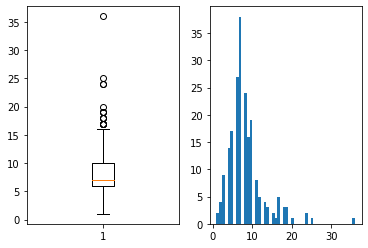

In [668]:
len_result = [len(s) for s in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [669]:
max_len=20

In [670]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [671]:
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 98.08612440191388


In [672]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[['0' '100']
 ['109' '100']]


In [673]:
word_to_index = tokenizer.word_index
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [674]:
print('빈도수 상위 1등 단어 : {}'.format(index_to_word[4]))


빈도수 상위 1등 단어 : 좋


In [675]:
print('빈도수 상위 100등 단어 : {}'.format(index_to_word[100]))


빈도수 상위 100등 단어 : 아니


In [676]:
# (index 변환 전) X_train[0] 한국어 단어 표시
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]]))

사람 대하 아르바이트 공무원 공단 쎄 회사 프로세스 출퇴근 아르바이트 크


In [677]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [678]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [679]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [680]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(209, 20)
(209,)
(90, 20)
(90,)


In [681]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [682]:
y_train

array(['100', '100', '100', '0', '100', '0', '100', '100', '0', '100',
       '100', '0', '0', '0', '100', '0', '100', '0', '0', '0', '100', '0',
       '100', '100', '100', '0', '0', '100', '0', '0', '100', '0', '0',
       '100', '100', '100', '100', '100', '0', '0', '100', '0', '100',
       '100', '100', '100', '100', '100', '100', '100', '100', '100',
       '100', '100', '0', '100', '100', '100', '0', '0', '100', '0', '0',
       '0', '0', '0', '100', '0', '0', '0', '100', '100', '100', '100',
       '100', '0', '0', '0', '100', '0', '100', '0', '0', '0', '0', '0',
       '100', '0', '0', '0', '100', '0', '0', '0', '100', '0', '0', '100',
       '100', '100', '0', '100', '100', '100', '0', '0', '100', '100',
       '0', '0', '100', '100', '100', '100', '100', '0', '0', '0', '0',
       '100', '0', '100', '0', '0', '0', '0', '0', '0', '100', '100',
       '100', '0', '100', '100', '100', '100', '0', '100', '100', '0',
       '0', '100', '0', '100', '0', '0', '0', '100', '100', '0'

In [683]:
preds = nb.predict(X_test)

In [684]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[21 19]
 [22 28]]


              precision    recall  f1-score   support

           0       0.49      0.53      0.51        40
         100       0.60      0.56      0.58        50

    accuracy                           0.54        90
   macro avg       0.54      0.54      0.54        90
weighted avg       0.55      0.54      0.55        90



In [689]:
# Logistic Regression training

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
# Logistic Regression prediction
y_pred_logreg = logreg.predict(X_test)
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.45      0.60      0.52        40
         100       0.57      0.42      0.48        50

    accuracy                           0.50        90
   macro avg       0.51      0.51      0.50        90
weighted avg       0.52      0.50      0.50        90



In [686]:
svc = SVC(gamma='scale', kernel='linear')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))


              precision    recall  f1-score   support

           0       0.46      0.78      0.57        40
         100       0.59      0.26      0.36        50

    accuracy                           0.49        90
   macro avg       0.52      0.52      0.47        90
weighted avg       0.53      0.49      0.46        90



In [687]:
ANN = MLPClassifier(solver='lbfgs', alpha=1, hidden_layer_sizes=(20, 2), random_state=1)
ANN.fit(X_train, y_train)
y_pred_ANN = ANN.predict(X_test)
print(classification_report(y_test, y_pred_ANN))

              precision    recall  f1-score   support

           0       0.50      0.82      0.62        40
         100       0.71      0.34      0.46        50

    accuracy                           0.56        90
   macro avg       0.60      0.58      0.54        90
weighted avg       0.62      0.56      0.53        90

